# Import packages

In [25]:
import sys
from brian2 import *
import sympy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import signal
from scipy import optimize
from scipy import stats
import scipy
from scipy.stats import gaussian_kde
import pickle
import yaml
import time
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42


# define paths

In [2]:
# You must define the path to the raw data (downloaded from the database)
# the raw data to plot example cells is not part of the github directory
data_folder = '/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw'

In [3]:
top_dir = Path.cwd().resolve().parents[0] #this is the path to the folder you should be running these notebooks from (Perks_Sawtell_2022)

#primary resource folders:
script_folder = top_dir / 'scripts'
# data_folder = top_dir / 'data_raw'

#folders with processed data:
df_folder = top_dir / 'data_processed/df_cmdintact'
meta_data_folder = top_dir / 'data_processed/GRC_properties_Meta'

#where to save any figures that are generated:
#change as needed. Default is the location where Perks_Sawtell_2022 lives (if you are running this script from that folder)
figure_folder = Path.cwd().resolve().parents[1] / 'Perks_Sawtell_2022_FiguresComponents'

#for storing simulation states
sim_filename = 'grc_model_initialized.pickle'
sim_filepath = top_dir / 'data_processed/grc_model_simulations' / sim_filename 

# import custom functions from scripts folder

In [4]:
sys.path.append(script_folder)
from ClassDef_AmplitudeShift_Stable import AmpShift_Stable #this is the function that imports all of the cell_data structures. Needed if plotting any example cells. 
from FunctionDefinitions import *

# configure figure styles

In [5]:
sns.set_style("ticks")
sns.set_context("paper")
rc = set_fig_style()
matplotlib.rcParams.update(rc)

# Load GC metadata from yaml files

In [6]:
with open(top_dir / 'data_processed/cell_type_metadata.yaml', 'r') as file:
    cell_type = yaml.load(file,Loader=yaml.FullLoader)[0]
    
with open(top_dir / 'data_processed/Vm_offset_metadata.yaml', 'r') as file:
    Vm_offset = yaml.load(file,Loader=yaml.FullLoader)[0]

#  GC properties (unsubtracted CvsU)

## import dataframe 

In [7]:
path = top_dir / 'data_processed' / 'df_cmdintact'
files = [e for e in path.iterdir() if e.is_file() and e.suffix=='.csv']
keys = [f.name[0:-4] for f in sorted(files)]
meta_df = pd.DataFrame(columns = None)
for f in files:
    thisdf = pd.read_csv(f)
    meta_df = meta_df.append(thisdf,ignore_index = True)

meta_df['cell_type'] = meta_df['exptname'].map(cell_type)

grc_df = meta_df[(meta_df['cell_type']=='s') | (meta_df['cell_type']=='d')]

## (S2) coupled versus prediction at baseline amp split by cell type

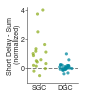

In [8]:
hfig,ax = create_fig_tuning()
sns.despine(hfig)
ax.hlines(0,-0.5,1.5,color = 'gray',lw = 1,linestyle='--')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-1,4.2)
ax.set_ylabel('Short Delay - Sum \n (normalized)',linespacing=0.9)
ax.set_xticklabels('')
sns.stripplot(y=(grc_df['c_epsp_amp']-grc_df['p_epsp_amp'])/grc_df['p_epsp_amp'],
              x = grc_df['cell_type'],
              palette = sns.color_palette([sns.xkcd_rgb['icky green'],sns.xkcd_rgb['teal blue']]),
             jitter=0.25,alpha = 0.75,s = sqrt(10))
ax.set_xlabel('')
ax.set_xticklabels(['SGC','DGC'])
figsave(figure_folder,'S2_baseline_CDcoupleVpredict')

#### t-test on difference from 0

In [9]:
# stats.ttest_ind(grc_df[s_ind]['c_epsp_amp']/grc_df[s_ind]['p_epsp_amp'],
#                 grc_df[s_ind]['p_epsp_amp']/grc_df[s_ind]['p_epsp_amp'],
#                nan_policy='omit')
s_ind = grc_df['cell_type'].isin(['s'])
sgcresult = (grc_df[s_ind]['c_epsp_amp']-grc_df[s_ind]['p_epsp_amp'])/grc_df[s_ind]['p_epsp_amp']
d_ind = grc_df['cell_type'].isin(['d'])
dgcresult = (grc_df[d_ind]['c_epsp_amp']-grc_df[d_ind]['p_epsp_amp'])/grc_df[d_ind]['p_epsp_amp']
r = stats.ttest_ind(sgcresult.drop(3).values, dgcresult.values,0,nan_policy='omit')
print('sgc dgc difference ttest from 0: t(%i)= %.2f, p=%0.5f' % ((sum(s_ind)+sum(d_ind))-2,r[0],r[1]))

s_ind = grc_df['cell_type'].isin(['s'])
r = stats.ttest_1samp((grc_df[s_ind]['c_epsp_amp'].drop(3)-grc_df[s_ind]['p_epsp_amp'].drop(3))/grc_df[s_ind]['p_epsp_amp'].drop(3)
                      ,0,nan_policy='omit')
print('sgc ttest from 0: t(%i)= %.2f, p=%0.5f' % (sum(s_ind)-1,r[0],r[1]))

d_ind = grc_df['cell_type'].isin(['d'])
r = stats.ttest_1samp((grc_df[d_ind]['c_epsp_amp']-grc_df[d_ind]['p_epsp_amp'])/grc_df[d_ind]['p_epsp_amp']
                      ,0,nan_policy='omit')
print('dgc ttest from 0: t(%i)= %.2f, p=%0.5f' % (sum(d_ind)-1,r[0],r[1]))

sgc dgc difference ttest from 0: t(48)= 1.63, p=0.10982
sgc ttest from 0: t(19)= 1.47, p=0.15928
dgc ttest from 0: t(29)= 1.45, p=0.15763


In [10]:
(grc_df[s_ind]['c_epsp_amp'].drop(3)-grc_df[s_ind]['p_epsp_amp'].drop(3))/grc_df[s_ind]['p_epsp_amp'].drop(3)

1     0.143808
5     2.503546
6     0.321358
7     0.431810
11   -0.507677
16    0.200993
23    0.513081
26   -0.022511
30   -5.329211
31    4.007151
32    1.173748
37    0.875016
43    1.632584
45         NaN
48    1.113503
49   -0.196354
50    1.007415
56    0.586199
58    3.730788
dtype: float64

In [11]:
sgcresult.drop(3).describe()

count    18.000000
mean      0.676958
std       1.951068
min      -5.329211
25%       0.158104
50%       0.549640
75%       1.158686
max       4.007151
dtype: float64

In [12]:
dgcresult.describe()

count    28.000000
mean      0.070804
std       0.257779
min      -0.381058
25%      -0.057932
50%       0.023991
75%       0.169794
max       0.989362
dtype: float64

In [13]:
grc_df['normdiff']=(grc_df['c_epsp_amp']-grc_df['p_epsp_amp'])/grc_df['p_epsp_amp']

WARNING    /Users/kperks/opt/anaconda3/envs/grc_study/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
 [py.warnings]


In [14]:
r = stats.wilcoxon(
    grc_df[grc_df['cell_type']=='s'].normdiff.dropna().values,
    mode='exact')

print('SGC wilcoxon')
print ('stat = ' + str(r[0]))
print ('p = ' + str(r[1]))
print('n = ' + str(len(
    grc_df[grc_df['cell_type']=='s'].normdiff.dropna().values)))

print('')
r = stats.wilcoxon(
    grc_df[grc_df['cell_type']=='d'].normdiff.dropna().values)
print('DGC wilcoxon')
print ('stat = ' + str(r[0]))
print ('p = ' + str(r[1]))
print('n = ' + str(len(
    grc_df[grc_df['cell_type']=='d'].normdiff.dropna().values)))

SGC wilcoxon
stat = 30.0
p = 0.007144927978515625
n = 19

DGC wilcoxon
stat = 141.0
p = 0.15800053800961822
n = 28


## coupled versus uncoupled ampshift

### SGC

#### Plot population results

In [15]:
#superficial grc
# meta_df_uc = pd.read_csv('DF_update_sGRCPopulation_UncoupledAmpShift.csv')
# meta_df_c = pd.read_csv('DF_sGRCPopulation_CoupledAmpShift.csv')
meta_df_uc = pd.read_csv(top_dir / 'data_processed/DF_SGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_SGC_CoupledAmpShift_revised10Sept.csv')

R_ampshift_u = []
R_ampshift_norm_u = []
R_ampshift_c = []
R_ampshift_norm_c = []
for a in np.unique(meta_df_uc['exptname']):
    subdf = meta_df_uc[meta_df_uc['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_u.append(r)
    r_scale = np.max(r)#subdf.peakAmp.mean()[40]#np.max(r)
    r = r/r_scale
    R_ampshift_norm_u.append(r)
    
    subdf = meta_df_c[meta_df_c['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_c.append(r)
    r = r/r_scale
    R_ampshift_norm_c.append(r)
    
R_ampshift_u = np.asarray(R_ampshift_u)
R_ampshift_norm_sgrc_u = np.asarray(R_ampshift_norm_u)
R_ampshift_c = np.asarray(R_ampshift_c)
R_ampshift_norm_sgrc_c = np.asarray(R_ampshift_norm_c)
stim_ampshift = np.unique(meta_df_uc.ampshift)

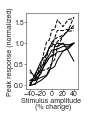

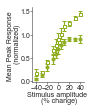

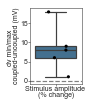

In [16]:
restrict_inds = stim_ampshift>=-40

hfig,ax = create_fig_tuning()

for expt_result in R_ampshift_norm_sgrc_u:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
for expt_result in R_ampshift_norm_sgrc_c:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='--',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
figsave(figure_folder,'Fig4_sgrcTuningCurves_UvC')

hfig,ax = create_fig_tuning()
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
             yerr=stats.sem(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
             fmt='s', mfc='white',ms = 3, color = sns.xkcd_rgb['icky green'], 
             ecolor = sns.xkcd_rgb['icky green'], capsize=2)

plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
             yerr=stats.sem(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
             fmt='o', ms = 3, color = sns.xkcd_rgb['icky green'], 
             ecolor = sns.xkcd_rgb['icky green'], capsize=2)

ax.set_ylabel('Mean Peak Response \n (normalized)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
ax.set_ylim(-0.03,1.6)
sns.despine(hfig)
figsave(figure_folder,'Fig3_sgrcTuningCurves_LongVsShort_MeanSem')

dv_u = []
for r in R_ampshift_u:
    dv_u.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_c = np.asarray(dv_c).T


hfig,ax = create_fig_tuning()
sns.boxplot(y=np.round(dv_c - dv_u), whis=np.inf,saturation = 0.5,ax=ax)
ax.hlines(0,-1,1,linestyle = '--',color = 'gray')
sns.stripplot(y=np.round(dv_c - dv_u),s= sqrt(10),color = 'black',jitter = 0.4,ax=ax)
ax.set_ylabel('dv min/max \n coupled-uncoupled (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
figsave(figure_folder,'Fig4_sgrcTuningScatter_UvC')

In [17]:
restrict_inds = ((stim_ampshift>=-10)&(stim_ampshift<=10))

dv_u = []
for r in R_ampshift_u[:,restrict_inds]:
    dv_u.append(r[-1] - r[0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[-1] - r[0])
dv_c = np.asarray(dv_c).T

print('uncoupled: mean mV change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_u),np.std(dv_u),stats.sem(dv_u)))
print('coupled: mean mV change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c),np.std(dv_c),stats.sem(dv_c)))


uncoupled: mean mV change 8.28, 5.55 std, 2.77 sem
coupled: mean mV change 27.91, 8.75 std, 4.37 sem


In [18]:
restrict_inds = ((stim_ampshift>=-10)&(stim_ampshift<=10))

dv_u = []
for r in R_ampshift_norm_sgrc_u[:,restrict_inds]:
    dv_u.append(r[-1] - r[0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_norm_sgrc_c:
    dv_c.append(r[-1] - r[0])
dv_c = np.asarray(dv_c).T

print('uncoupled gain: mean percent change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_u),np.std(dv_u),stats.sem(dv_u)))
print('coupled gain: mean percent change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c),np.std(dv_c),stats.sem(dv_c)))

print('coupled versus uncoupled gain: mean max percent change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c-dv_u),np.std(dv_c-dv_u),stats.sem(dv_c-dv_u)))
print('coupled versus uncoupled gain: mean max percent change %0.2f min, %0.2f max' %(np.min(dv_c-dv_u),np.max(dv_c-dv_u)))
print(100*(dv_c-dv_u))

uncoupled gain: mean percent change 0.36, 0.17 std, 0.09 sem
coupled gain: mean percent change 1.28, 0.15 std, 0.07 sem
coupled versus uncoupled gain: mean max percent change 0.91, 0.22 std, 0.11 sem
coupled versus uncoupled gain: mean max percent change 0.55 min, 1.15 max
[103.69901725 102.98215511  54.70491934 115.46014878  79.49255685]


#### prep a dataframe for t-test and ANOVA on population data

In [19]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_SGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_SGC_CoupledAmpShift_revised10Sept.csv')

eid = []
ramp = []
samp = []
cond = []

for i,n in enumerate(np.unique(meta_df_u['exptname'])):
    
    exptdf = meta_df_u[meta_df_u['exptname']==n]
    subdf = exptdf.groupby('ampshift')
    r = subdf.peakAmp.mean().values
    # get scaling factor to normalize all values to max uncoupled
    r_scale = np.max(r)
    for a in np.unique(exptdf['ampshift']):
        ampdf = exptdf[exptdf['ampshift']==a]
        eid.append(i)
        cond.append('u')
        samp.append(a)
        r = ampdf['peakAmp'].mean()
        r = r/r_scale
        ramp.append(r)
        
    exptdf = meta_df_c[meta_df_c['exptname']==n]
    for a in np.unique(exptdf['ampshift']):
        ampdf = exptdf[exptdf['ampshift']==a]
        eid.append(i)
        cond.append('c')
        samp.append(a)
        r = ampdf['peakAmp'].mean()
        r = r/r_scale
        ramp.append(r)
    


anal_df = pd.DataFrame({
    'eid' : eid,
    'cond' : cond,
    'samp' : samp,
    'ramp' : ramp
})

#### Kruskal wallis for effect of condition

In [23]:
scipy.stats.kruskal(*[group["ramp"].values for name, group in anal_df.groupby('cond')])

KruskalResult(statistic=10.058722448452581, pvalue=0.0015162833569207378)

#### two-factor repeated measures anova with statsmodels on normalized data

In [26]:
# formula = 'ramp ~ C(cond) + C(samp) + C(cond):C(samp)'
formula = 'ramp ~ C(cond) * C(samp)'
model = ols(formula, data = anal_df).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
C(cond),1.847661,1.0,55.471215,6.124206e-11
C(samp),14.720920,10.0,44.195738,4.699054e-30
C(cond):C(samp),0.533894,10.0,1.602879,1.188818e-01
Residual,2.931145,88.0,NaN,NaN


#### statsmodels ANOVA by cell to test effect of condition, amp, and interaction on cells with enough trials to test per cell

In [27]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_SGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_SGC_CoupledAmpShift_revised10Sept.csv')

p_cond = []
p_amp = []
p_interact = []
ntrials_p = []
ntrials_c = []
n_tested = 0
n_trials_min = 5
for expt in np.unique(meta_df_u['exptname']):
# expt = '20200718_000'
    expt_df_u = meta_df_u[meta_df_u['exptname']==expt]
    expt_df_u.insert(1, 'cond', 'u')
    expt_df_c = meta_df_c[meta_df_c['exptname']==expt]
    expt_df_c.insert(1, 'cond', 'c')    
    expt_df = expt_df_u.append(expt_df_c)
    
  
    if (((len(expt_df_u)/11)>=n_trials_min) & ((len(expt_df_c)/11)>=n_trials_min)):
        n_tested += 1
        # expt_df
    #     formula = 'peakAmp ~ C(cond) * C(ampshift)'
        formula = 'peakAmp ~ C(cond) + C(ampshift) + C(cond):C(ampshift)'
        model = ols(formula, data = expt_df).fit()
        aov_table = anova_lm(model) #, typ=2)

        p_cond.append(aov_table['PR(>F)'].loc['C(cond)'])
#         p_cond.append(aov_table['PR(>F)'].loc['C(cond)'])
        p_amp.append(aov_table['PR(>F)'].loc['C(ampshift)'])
        p_interact.append(aov_table['PR(>F)'].loc['C(cond):C(ampshift)'])
# p_cond = np.asarray(p_cond)
p_cond = np.asarray(p_cond)

print(p_cond<0.001)

print(' significant effect (p<0.001 ANOVA) of condition in ' + 
     str(np.count_nonzero(p_cond<0.001)) + 
     ' SGC out of ' +
     str(n_tested) + ' with more than ' + str(n_trials_min) + ' trials')

print(' significant effect (p<0.01 ANOVA) of condition in ' + 
     str(np.count_nonzero(p_cond<0.01)) + 
     ' SGC out of ' +
     str(n_tested) + ' with more than ' + str(n_trials_min) + ' trials')


print('p delay: ')
print(p_cond)
print('p amplitdue: ')
print(p_amp)
print('p interaction: ')
print(p_interact)
# display(aov_table)

[ True  True  True  True]
 significant effect (p<0.001 ANOVA) of condition in 4 SGC out of 4 with more than 5 trials
 significant effect (p<0.01 ANOVA) of condition in 4 SGC out of 4 with more than 5 trials
p delay: 
[3.16975317e-04 3.46888542e-26 1.16469027e-25 4.13158913e-28]
p amplitdue: 
[1.4305555068565478e-53, 1.1042288659704157e-55, 3.4111305857942757e-125, 1.933643096760045e-121]
p interaction: 
[5.900924681779239e-07, 2.9288308154991367e-05, 6.591461021377624e-13, 4.54236020139316e-12]


#### statsmodels ANOVA by cell to test effect of condition, amp, and interaction on all cells (use raw mean per cell; not normalized)

In [28]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_SGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_SGC_CoupledAmpShift_revised10Sept.csv')
meta_df_u.insert(1, 'cond', 'u')

meta_df_c.insert(1, 'cond', 'c')    

df = meta_df_u.append(meta_df_c)
df = df.groupby(['exptname','cond','ampshift']).agg(peakAmp=pd.NamedAgg(column='peakAmp',aggfunc=mean)).reset_index()

formula = 'peakAmp ~ C(cond) + C(ampshift) + C(cond):C(ampshift)'
model = ols(formula, data = df).fit()
aov_table = anova_lm(model) #, typ=2)

display(aov_table)


scipy.stats.kruskal(*[group["peakAmp"].values for name, group in df.groupby('cond')])
#     anal_df.groupby('cond')['ramp'])

,df,sum_sq,mean_sq,F,PR(>F)
C(cond),1.0,927.221426,927.221426,12.976687,5.215877e-04
C(ampshift),10.0,7526.865562,752.686556,10.534030,1.682825e-11
C(cond):C(ampshift),10.0,260.445823,26.044582,0.364500,9.586452e-01
Residual,88.0,6287.851723,71.452860,NaN,NaN


KruskalResult(statistic=6.349332142059382, pvalue=0.011742549621692513)


### DGC

#### Plot population results

In [29]:
#deep grc
meta_df_uc = pd.read_csv(top_dir / 'data_processed/DF_DGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_DGC_CoupledAmpShift_revised10Sept.csv')
R_ampshift_u = []
R_ampshift_norm_u = []
R_ampshift_c = []
R_ampshift_norm_c = []
for a in np.unique(meta_df_uc['exptname']):
    subdf = meta_df_uc[meta_df_uc['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_u.append(r)
    r_scale = np.max(r)
    r = r/r_scale
    R_ampshift_norm_u.append(r)
    
    subdf = meta_df_c[meta_df_c['exptname']==a].groupby('ampshift')
    r = subdf.peakAmp.mean().values
    R_ampshift_c.append(r)
    r = r/r_scale
    R_ampshift_norm_c.append(r)
    
R_ampshift_u = np.asarray(R_ampshift_u)
R_ampshift_norm_dgrc_u = np.asarray(R_ampshift_norm_u)
R_ampshift_c = np.asarray(R_ampshift_c)
R_ampshift_norm_dgrc_c = np.asarray(R_ampshift_norm_c)
stim_ampshift = np.unique(meta_df_uc.ampshift)

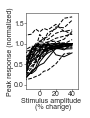

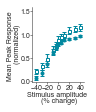

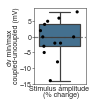

In [30]:
restrict_inds = stim_ampshift>=-40
hfig,ax = create_fig_tuning()

for expt_result in R_ampshift_norm_dgrc_u:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
for expt_result in R_ampshift_norm_dgrc_c:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='--',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
figsave(figure_folder,'Fig4_dgrcTuningCurves_UvC')


hfig,ax = create_fig_tuning()
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_dgrc_c[:,restrict_inds],0),
             yerr=stats.sem(R_ampshift_norm_dgrc_c[:,restrict_inds],0),
             fmt='s', mfc='white',ms = 3, color = sns.xkcd_rgb['teal blue'], 
             ecolor = sns.xkcd_rgb['teal blue'], capsize=2)

plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_dgrc_u[:,restrict_inds],0),
             yerr=stats.sem(R_ampshift_norm_dgrc_u[:,restrict_inds],0),
             fmt='o', ms = 3, color = sns.xkcd_rgb['teal blue'], 
             ecolor = sns.xkcd_rgb['teal blue'], capsize=2)

ax.set_ylabel('Mean Peak Response \n (normalized)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
ax.set_ylim(-0.03,1.6)
sns.despine(hfig)
figsave(figure_folder,'Fig3_dgrcTuningCurves_LongVsShort_MeanSem')


dv_u = []
for r in R_ampshift_u:
    dv_u.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_c = np.asarray(dv_c).T


hfig,ax = create_fig_tuning()
sns.boxplot(y=np.round(dv_c - dv_u), whis=np.inf,saturation = 0.5,ax=ax)
ax.hlines(0,-1,1,linestyle = '--',color = 'gray')
sns.stripplot(y=np.round(dv_c - dv_u),s= sqrt(10),color = 'black',jitter = 0.4,ax=ax)
ax.set_ylabel('dv min/max \n coupled-uncoupled (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
figsave(figure_folder,'Fig4_dgrcTuningScatter_UvC')

In [31]:
restrict_inds = ((stim_ampshift>=-10)&(stim_ampshift<=10))

dv_u = []
for r in R_ampshift_u[:,restrict_inds]:
    dv_u.append(r[-1] - r[0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[-1] - r[0])
dv_c = np.asarray(dv_c).T

print('uncoupled: mean mV change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_u),np.std(dv_u),stats.sem(dv_u)))
print('coupled: mean mV change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c),np.std(dv_c),stats.sem(dv_c)))


uncoupled: mean mV change 8.11, 8.10 std, 2.34 sem
coupled: mean mV change 26.75, 14.63 std, 4.22 sem


In [32]:
restrict_inds = ((stim_ampshift>=-10)&(stim_ampshift<=10))

dv_u = []
for r in R_ampshift_norm_dgrc_u[:,restrict_inds]:
    dv_u.append(r[-1] - r[0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_norm_dgrc_c:
    dv_c.append(r[-1] - r[0])
dv_c = np.asarray(dv_c).T

print('uncoupled gain: mean percent change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_u),np.std(dv_u),stats.sem(dv_u)))
print('coupled gain: mean percent change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c),np.std(dv_c),stats.sem(dv_c)))

print('coupled versus uncoupled gain: mean max percent change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c-dv_u),np.std(dv_c-dv_u),stats.sem(dv_c-dv_u)))
print('coupled versus uncoupled gain: mean max percent change %0.2f min, %0.2f max' %(np.min(dv_c-dv_u),np.max(dv_c-dv_u)))
print(100*(dv_c-dv_u))

uncoupled gain: mean percent change 0.27, 0.17 std, 0.05 sem
coupled gain: mean percent change 0.95, 0.21 std, 0.06 sem
coupled versus uncoupled gain: mean max percent change 0.68, 0.31 std, 0.09 sem
coupled versus uncoupled gain: mean max percent change 0.27 min, 1.30 max
[ 37.31644447  55.55419922  56.96818982 129.64190493  88.10438634
  47.7629604   80.1380699   27.26064484 118.21540492  41.40118969
  37.38463404  86.03864647  82.9274071 ]


#### prep a dataframe for t-test and ANOVA on population data

In [34]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_DGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_DGC_CoupledAmpShift_revised10Sept.csv')

eid = []
ramp = []
samp = []
cond = []

for i,n in enumerate(np.unique(meta_df_u['exptname'])):
    
    exptdf = meta_df_u[meta_df_u['exptname']==n]
    subdf = exptdf.groupby('ampshift')
    r = subdf.peakAmp.mean().values
    # get scaling factor to normalize all values to max uncoupled
    r_scale = np.max(r)
    for a in np.unique(exptdf['ampshift']):
        ampdf = exptdf[exptdf['ampshift']==a]
        eid.append(i)
        cond.append('u')
        samp.append(a)
        r = ampdf['peakAmp'].mean()
        r = r/r_scale
        ramp.append(r)
        
    exptdf = meta_df_c[meta_df_c['exptname']==n]
    for a in np.unique(exptdf['ampshift']):
        ampdf = exptdf[exptdf['ampshift']==a]
        eid.append(i)
        cond.append('c')
        samp.append(a)
        r = ampdf['peakAmp'].mean()
        r = r/r_scale
        ramp.append(r)
    


anal_df = pd.DataFrame({
    'eid' : eid,
    'cond' : cond,
    'samp' : samp,
    'ramp' : ramp
})

#### two-factor repeated measures anova with statsmodels

In [36]:
# formula = 'ramp ~ C(cond) + C(samp) + C(cond):C(samp)'
formula = 'ramp ~ C(cond) * C(samp)'
model = ols(formula, data = anal_df).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
C(cond),1.047268,1.0,21.368831,5.933956e-06
C(samp),26.845833,10.0,54.777199,1.158831e-58
C(cond):C(samp),0.184956,10.0,0.377391,9.557686e-01
Residual,12.938412,264.0,NaN,NaN


#### Kruskal Wallis on effect of condition

In [37]:

scipy.stats.kruskal(*[group["ramp"].values for name, group in anal_df.groupby('cond')])
#     anal_df.groupby('cond')['ramp'])

KruskalResult(statistic=9.039404707959045, pvalue=0.0026422166233004336)

#### statsmodels ANOVA by cell to test effect of condition, amp, and interaction on cells with enough trials to test per cell

In [38]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_DGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_DGC_CoupledAmpShift_revised10Sept.csv')

p_cond = []
p_amp = []
p_interact = []
ntrials_p = []
ntrials_c = []
n_tested = 0
n_trials_min = 5
for expt in np.unique(meta_df_u['exptname']):
# expt = '20200718_000'
    expt_df_u = meta_df_u[meta_df_u['exptname']==expt]
    expt_df_u.insert(1, 'cond', 'u')
    expt_df_c = meta_df_c[meta_df_c['exptname']==expt]
    expt_df_c.insert(1, 'cond', 'c')    
    expt_df = expt_df_u.append(expt_df_c)
    
  
    if (((len(expt_df_u)/11)>=n_trials_min) & ((len(expt_df_c)/11)>=n_trials_min)):
        n_tested += 1
        # expt_df
    #     formula = 'peakAmp ~ C(cond) * C(ampshift)'
        formula = 'peakAmp ~ C(cond) + C(ampshift) + C(cond):C(ampshift)'
        model = ols(formula, data = expt_df).fit()
        aov_table = anova_lm(model) #, typ=2)

        p_cond.append(aov_table['PR(>F)'].loc['C(cond)'])
#         p_cond.append(aov_table['PR(>F)'].loc['C(cond)'])
        p_amp.append(aov_table['PR(>F)'].loc['C(ampshift)'])
        p_interact.append(aov_table['PR(>F)'].loc['C(cond):C(ampshift)'])
# p_cond = np.asarray(p_cond)
p_cond = np.asarray(p_cond)

print(p_cond<0.001)

print(' significant effect (p<0.001 ANOVA) of condition in ' + 
     str(np.count_nonzero(p_cond<0.001)) + 
     ' DGC out of ' +
     str(n_tested) + ' with more than ' + str(n_trials_min) + ' trials')

print(' significant effect (p<0.01 ANOVA) of condition in ' + 
     str(np.count_nonzero(p_cond<0.01)) + 
     ' DGC out of ' +
     str(n_tested) + ' with more than ' + str(n_trials_min) + ' trials')


print('p delay: ')
print(p_cond)
print('p amplitdue: ')
print(p_amp)
print('p interaction: ')
print(p_interact)
# display(aov_table)

[ True  True  True False  True  True  True False False]
 significant effect (p<0.001 ANOVA) of condition in 6 DGC out of 9 with more than 5 trials
 significant effect (p<0.01 ANOVA) of condition in 7 DGC out of 9 with more than 5 trials
p delay: 
[1.01791253e-11 3.32887296e-37 3.31594644e-09 9.92243348e-01
 8.08367507e-67 2.97070850e-23 6.30964667e-19 1.59838046e-01
 1.09776571e-03]
p amplitdue: 
[1.2764384526413873e-127, 1.802069799331527e-56, 8.088597081222844e-56, 7.316242605894207e-46, 6.993456799906277e-124, 5.006892753621943e-57, 2.8868771122896005e-94, 2.4171278501791707e-98, 6.844910826959184e-154]
p interaction: 
[5.022831693283214e-11, 9.08650984734251e-10, 0.3909765641303829, 0.3365029830107356, 5.639000787159364e-18, 4.3493001352727915e-09, 3.061316669086097e-06, 0.08640885100956942, 1.738906169793234e-44]


#### statsmodels ANOVA by cell to test effect of condition, amp, and interaction on all cells (use raw mean per cell; not normalized)

In [39]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_DGC_UncoupledAmpShift_revised10Sept.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_DGC_CoupledAmpShift_revised10Sept.csv')
meta_df_u.insert(1, 'cond', 'u')

meta_df_c.insert(1, 'cond', 'c')    

df = meta_df_u.append(meta_df_c)
df = df.groupby(['exptname','cond','ampshift']).agg(peakAmp=pd.NamedAgg(column='peakAmp',aggfunc=mean)).reset_index()

formula = 'peakAmp ~ C(cond) + C(ampshift) + C(cond):C(ampshift)'
model = ols(formula, data = df).fit()
aov_table = anova_lm(model) #, typ=2)

display(aov_table)


scipy.stats.kruskal(*[group["peakAmp"].values for name, group in df.groupby('cond')])
#     anal_df.groupby('cond')['ramp'])

,df,sum_sq,mean_sq,F,PR(>F)
C(cond),1.0,245.716197,245.716197,1.287466,2.575446e-01
C(ampshift),10.0,24693.148579,2469.314858,12.938339,2.322302e-18
C(cond):C(ampshift),10.0,43.263568,4.326357,0.022669,9.999998e-01
Residual,264.0,50385.072321,190.852547,NaN,NaN


KruskalResult(statistic=1.8163100757335542, pvalue=0.17775312705592403)

### example cells

#### SGC 20200718_000

In [42]:
exptname = '20200718_000'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw/20200718_000.smr


In [43]:
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

# bias -65
########
bout_uc = [expt.get_bout_win('R','Keyboard')[0],
          expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

In [32]:
eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>=-40

Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]

Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)


bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

/Users/kperks/mnt/engram/spikedata/data_raw/20200718/20200718_000.smr


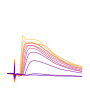

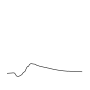

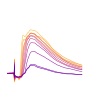

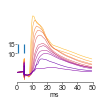

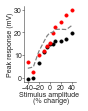

In [15]:
hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample1_uncoupled')

hfig,ax = create_fig()
ax.plot(xtime-0.5,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_grcExample1_cd')



hfig,ax = create_fig()
# colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
# colinds = array([c for c in reversed(colinds)])
# trialmat = trialmat[:,restrict_inds]
# trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,35)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample1_predicted')

hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);

ax.vlines(4.5,10,15)
ax.vlines(0.5,10,15)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_ylim(-5,35)
ax.set_yticks([10,15])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('ms');

figsave(figure_folder,'Fig4_grcExample1_coupled')


hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],
            color = 'black',s=10,fmt = 'o')
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],
            color = 'red',s=10)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_grcExample1_scatter')

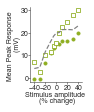

In [38]:

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_uc],
            color = sns.xkcd_rgb['icky green'],s=10,marker = 'o')
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in Ramp_p],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_c],
            edgecolors = sns.xkcd_rgb['icky green'],s=10,marker = 's',color='white')
ax.set_ylabel('Mean Peak Response \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig3_grcExample1_scatter')

#### DGC 20200719_004

In [39]:
exptname = '20200719_004'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/engram_share/home/kep2142/spikedata/data_raw/20200719/20200719_004.smr


In [40]:
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

#hyperpolarized
bout_uc = [expt.get_bout_win('R','Keyboard')[3]]
bout_c = [expt.get_bout_win('N','Keyboard')[1]]

sweepdur = 0.05
r_onset = int(0.006/dt)

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>=-40



Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]



Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)


bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T


Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)

/Users/kperks/mnt/engram/spikedata/data_raw/20200719/20200719_004.smr


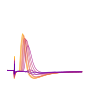

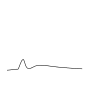

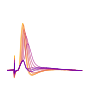

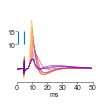

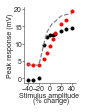

In [16]:
hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample2_uncoupled')

hfig,ax = create_fig()
ax.plot(xtime-0.5,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_grcExample2_cd')

hfig,ax = create_fig()
# colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
# colinds = array([c for c in reversed(colinds)])
# trialmat = trialmat[:,restrict_inds]
# trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample2_predicted')


hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
    
ax.vlines(4.5,10,15)
ax.vlines(0.5,10,15)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_ylim(-5,25)
ax.set_yticks([10,15])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('ms');

figsave(figure_folder,'Fig4_grcExample2_coupled')

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],
            color = 'black',s=10)
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],
            color = 'red',s=10)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_grcExample2_scatter')

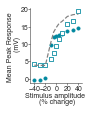

In [41]:

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_uc],
            color = sns.xkcd_rgb['teal blue'],s=10,marker = 'o')
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in Ramp_p],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_c],
            edgecolors = sns.xkcd_rgb['teal blue'],s=10,marker = 's',color='white')
ax.set_ylabel('Mean Peak Response \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig3_grcExample2_scatter')

#### DGC 20200607_002

In [45]:
exptname = '20200607_002'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])

expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw/20200607_002.smr


In [49]:
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[0],
           expt.get_bout_win('R','Keyboard')[1]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>=-40



Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]


Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)


bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 
trialmat = np.asarray([sweep-sweep[0] for sweep in trialmat.T]).T


Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)



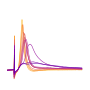

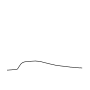

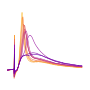

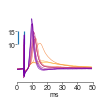

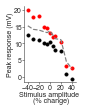

In [50]:

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample3_uncoupled')

hfig,ax = create_fig()
ax.plot(xtime-0.5,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_grcExample3_cd')

hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
# trialmat = trialmat[:,restrict_inds]
# trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_grcExample3_predicted')


hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
    
ax.vlines(4.5,10,15)
ax.vlines(0.5,10,15)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_ylim(-5,25)
ax.set_yticks([10,15])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('ms');

figsave(figure_folder,'Fig4_grcExample3_coupled')

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],
            color = 'black',s=10)
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],
            color = 'red',s=10)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_grcExample3_scatter')

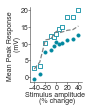

In [44]:
hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_uc],
            color = sns.xkcd_rgb['teal blue'],s=10,marker = 'o')
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in Ramp_p],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_c],
            edgecolors = sns.xkcd_rgb['teal blue'],s=10,marker = 's',color='white')
ax.set_ylabel('Mean Peak Response \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig3_grcExample3_scatter')

### Get shift in onset latency of responses
> use interactive plotting to go through the responses to each cell and extract onset

In [51]:
# created in 'GRC_properties_Meta_ipynb'
pickle_in = open(top_dir / 'data_processed/df_cmdintact/DGC_uncoupled_wavmat.pickle',"rb")
cell_data = pickle.load(pickle_in)
pickle_in.close()

In [52]:
list(cell_data.keys())

['20200719_004',
 '20200719_001',
 '20200606_005',
 '20200607_005',
 '20200607_004',
 '20200607_002',
 '20200525_001',
 '20200525_006',
 '20200312_002',
 '20200227_000',
 '20200226_002',
 '20200225_000',
 '20200115_002']

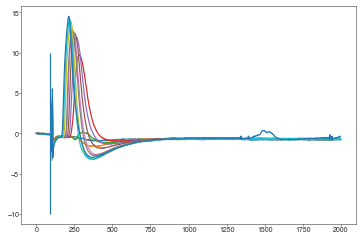

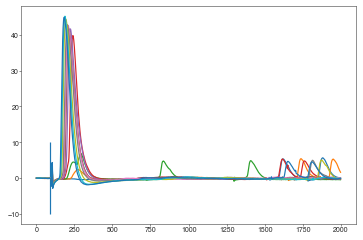

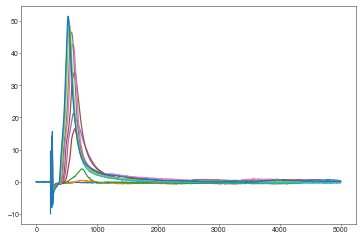

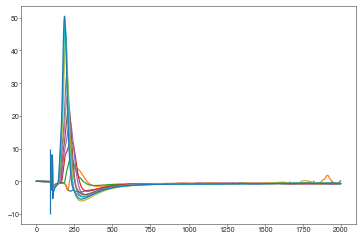

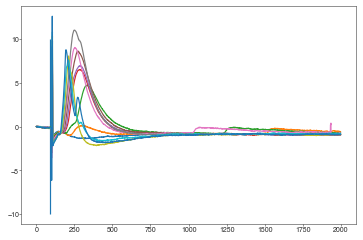

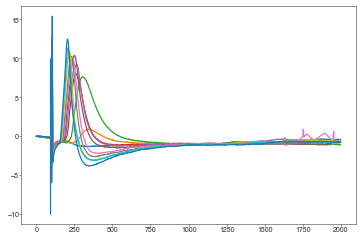

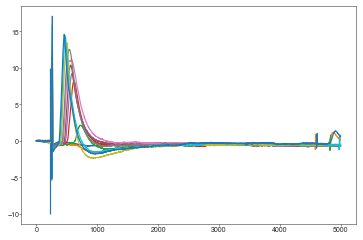

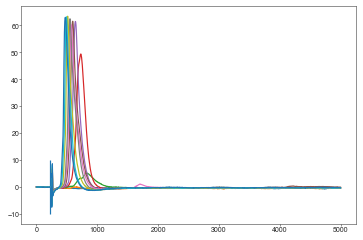

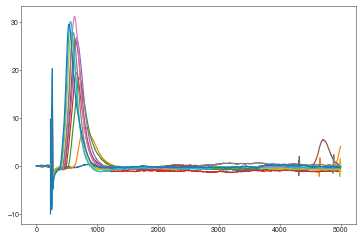

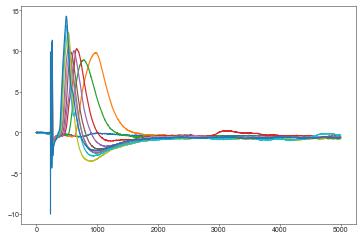

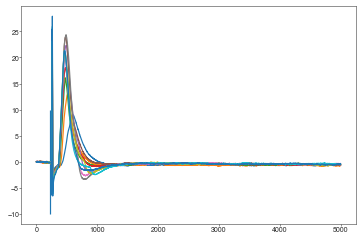

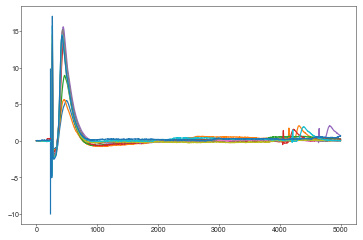

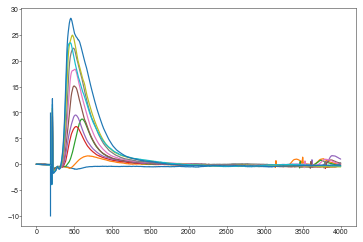

In [38]:
np.shape(cell_data['20200719_004'])
# plt.plot(cell_data['20200719_004']);

for _,c in cell_data.items():
    plt.figure()
    plt.plot(c);
    fs = int(len(c)/0.1)
    plt.vlines(int(0.0045*fs),-10,10)

In [26]:
# created in 'GRC_properties_Meta_ipynb'
pickle_in = open(top_dir / 'data_processed/df_cmdintact/SGC_uncoupled_wavmat.pickle',"rb")
cell_data = pickle.load(pickle_in)
pickle_in.close()

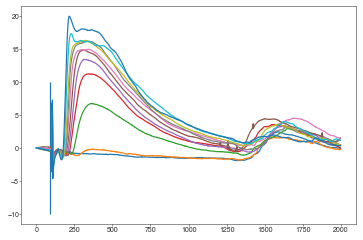

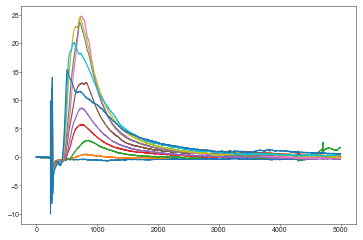

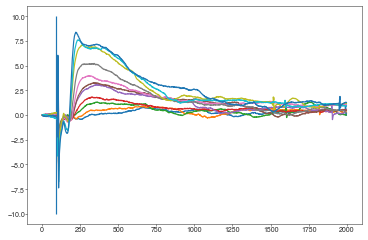

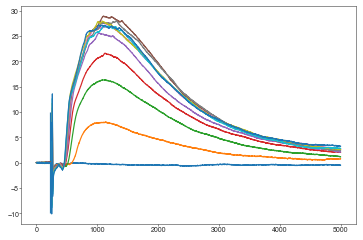

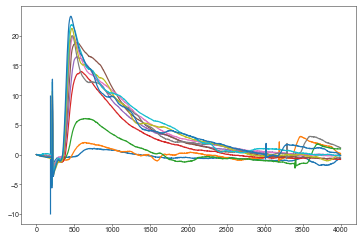

In [27]:
# np.shape(cell_data['20200719_004'])
# plt.plot(cell_data['20200719_004']);

for _,c in cell_data.items():
    plt.figure()
    plt.plot(c);
    fs = int(len(c)/0.1)
    plt.vlines(int(0.0045*fs),-10,10)

In [ ]:
# #### enable interactive plotting and create plot

# %matplotlib qt

# hfig = plt.figure(figsize = (5,8))
# ax = hfig.add_axes([0.2,0.2,0.7,0.7])

# #### interactive select SGC ES response onsets; save as numpy

# # which_cells = cell_meta_df[cell_meta_df['type']=='s'].index
# # which_cells = meta_df[meta_df['cell_type']=='s'].exptname.values

# # plt.plot(cell_data['20200719_004']);

# onset_mat = []
# onset = []
# i = 0
# for _,c in cell_data.items():

# #     while i < 3:
#     sweepdur = 0.1
#     fs = int(len(c)/sweepdur) # when these arrays were made, 100ms was the response window used
#     xtime = np.linspace(0,sweepdur*1000,len(c))
#     c = np.concatenate([c.T,c[:,10].reshape(1,-1)]).T
# #     onset = []
#     for sweep in c.T:
#         ax.cla()

#         ax.plot(xtime,sweep,color='black')
#         ax.set_xlim(4.5,20)
#         ax.set_ylim(-5,20)

#         x = np.asarray(hfig.ginput())
#     #     print(x)
#         onset.append(x[0][0])
#     #     print(x[0][0])

# #     onset_mat.append(np.asarray(onset))
#     i+=1

# onset.append(np.nan)
# # ax.cla()
# # sweeps_clip = []
# # offsetT = -2
# # x_clip = np.linspace(offsetT,50,int(50/1000/newdt)-int(offsetT/1000/newdt))
# # for o,sweep in zip(onset[1:],sweeps[:,0:-1].T):
# #     onsetind = int(o/1000/newdt)
# #     startind = onsetind + int((offsetT)/1000/newdt)
# #     stopind = onsetind + int((50)/1000/newdt)
# #     sweeps_clip.append(sweep[startind:stopind])
# #     ax.plot(x_clip,sweep[startind:stopind])
# # sweeps_clip = np.asarray(sweeps_clip).T
# # ax.set_xlim()

# # np.save(meta_data_folder / 'uncoupled_response_pop_sgrc_onset.npy',onset,allow_pickle=False)
# # np.save(meta_data_folder / 'uncoupled_response_pop_sgrc_sweeps.npy',sweeps,allow_pickle=False)
# # np.save(meta_data_folder / 'uncoupled_response_pop_sgrc_sweeps_clip.npy',sweeps_clip,allow_pickle=False)

# len(onset)

# print(len(onset))
# onset_mat = []
# for i in np.arange(2,len(onset),12):
#     print(i+11)
#     onset_mat.append(onset[i:i+11])
    
# onset_mat = np.asarray(onset_mat)

# # np.save(meta_data_folder / '<your_name>AmpshiftResponseOnset_DGC.npy',onset_mat,allow_pickle=False)

# x = [-40,-30,-20,-10,-5,0,5,10,20,30,40]
# np.shape(onset_mat)
# plt.figure()
# for o in onset_mat:
#     plt.scatter(x,o)

# np.shape(onset_mat)

# #### SGC

# # created in 'GRC_properties_Meta_ipynb'
# pickle_in = open(top_dir / 'data_processed/df_cmdintact/SGC_uncoupled_wavmat.pickle',"rb")
# cell_data = pickle.load(pickle_in)
# pickle_in.close()


# onset_mat = []
# onset = []
# i = 0
# for _,c in cell_data.items():

# #     while i < 3:
#     sweepdur = 0.1
#     fs = int(len(c)/sweepdur) # when these arrays were made, 100ms was the response window used
#     xtime = np.linspace(0,sweepdur*1000,len(c))
#     c = np.concatenate([c.T,c[:,10].reshape(1,-1)]).T
# #     onset = []
#     for sweep in c.T:
#         ax.cla()

#         ax.plot(xtime,sweep,color='black')
#         ax.set_xlim(4.5,20)
#         ax.set_ylim(-5,20)

#         x = np.asarray(hfig.ginput())
#     #     print(x)
#         onset.append(x[0][0])
#     #     print(x[0][0])

# #     onset_mat.append(np.asarray(onset))
#     i+=1

# onset.append(np.nan)
# # ax.cla()

# len(onset)

# print(len(onset))
# onset_mat = []
# for i in np.arange(2,len(onset),12):
#     print(i+11)
#     onset_mat.append(onset[i:i+11])
    
# onset_mat = np.asarray(onset_mat)

# # np.save(meta_data_folder / '<your_name>AmpshiftResponseOnset_SGC.npy',onset_mat,allow_pickle=False)

# x = [-40,-30,-20,-10,-5,0,5,10,20,30,40]
# np.shape(onset_mat)
# plt.figure()
# for o in onset_mat:
#     plt.scatter(x,o)

# #### close figure and return to inline plotting

# plt.close(hfig)

# %matplotlib inline

### GC scatter of response onset uncoupeld

In [53]:
dgc_onset = np.load(meta_data_folder / 'AmpshiftResponseOnset_DGC.npy')
sgc_onset = np.load(meta_data_folder / 'AmpshiftResponseOnset_SGC.npy')

x = [-40,-30,-20,-10,-5,0,5,10,20,30,40]

In [54]:
dgc_onset[dgc_onset<6] = np.nan
sgc_onset[sgc_onset<6] = np.nan

In [55]:
np.nanmean(dgc_onset,0)
stats.sem(dgc_onset,0,nan_policy = 'omit')

masked_array(data=[0.586700336832715, 0.4730309197211104,
                   0.3294350109080833, 0.2872828669743725,
                   0.24973232375754448, 0.22142581886432688,
                   0.20021292047959557, 0.16497444976731798,
                   0.1436902539182028, 0.1272646696193892,
                   0.13571798690881254],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value=1e+20)

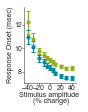

In [56]:
hfig,ax = create_fig_tuning()
ax.errorbar(x,np.nanmean(dgc_onset,0),
            yerr=stats.sem(dgc_onset,0,nan_policy = 'omit'),linestyle="None",
            color = sns.xkcd_rgb['teal blue'], capsize=2,fmt='o', mfc=sns.xkcd_rgb['teal blue'],ms=sqrt(10))
ax.errorbar(x,np.nanmean(sgc_onset,0),
            yerr=stats.sem(sgc_onset,0,nan_policy = 'omit'),linestyle="None",
            color = sns.xkcd_rgb['icky green'], capsize=2,fmt='o', mfc=sns.xkcd_rgb['icky green'],ms=sqrt(10))
ax.set_ylabel('Response Onset (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
# ax.set_ylim(-0.03,2.25)
sns.despine(hfig)
figsave(figure_folder,'Fig3_ResponseOnset_GCs')

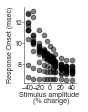

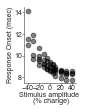

In [24]:
hfig,ax = create_fig_tuning()
for o in dgc_onset:
    plt.scatter(x,o,color = 'black',alpha = 0.5)
    ax.set_ylabel('Response Onset (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
# ax.set_ylim(-0.03,2.25)
sns.despine(hfig)

hfig,ax = create_fig_tuning()
for o in sgc_onset:
    plt.scatter(x,o,color = 'black',alpha = 0.5)
    ax.set_ylabel('Response Onset (msec)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
# ax.set_ylim(-0.03,2.25)
sns.despine(hfig)

In [25]:
np.shape(sgc_onset)

(5, 11)

### (S4) Output E

#### Plot population results

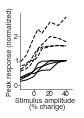

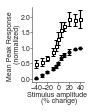

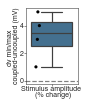

In [59]:
#Output E
meta_df_uc = pd.read_csv(top_dir / 'data_processed/DF_OutputEPopulation_SubUncoupledAmpShift.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_OutputPopulation_CoupledAmpShift.csv')
R_ampshift_u = []
R_ampshift_norm_u = []
R_ampshift_c = []
R_ampshift_norm_c = []
for a in np.unique(meta_df_uc['exptname']):
    subdf = meta_df_uc[meta_df_uc['exptname']==a].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift_u.append(r)
    r_scale = np.max(r)
    r = r/r_scale
    R_ampshift_norm_u.append(r)
    
    subdf = meta_df_c[meta_df_c['exptname']==a].groupby('ampshift')
    r = subdf.pspamp.mean().values
    R_ampshift_c.append(r)
    r = r/r_scale
    R_ampshift_norm_c.append(r)
    
R_ampshift_u = np.asarray(R_ampshift_u)
R_ampshift_norm_sgrc_u = np.asarray(R_ampshift_norm_u)
R_ampshift_c = np.asarray(R_ampshift_c)
R_ampshift_norm_sgrc_c = np.asarray(R_ampshift_norm_c)
stim_ampshift = np.unique(meta_df_uc.ampshift)

restrict_inds = stim_ampshift>=-40
hfig,ax = create_fig_tuning()
# hfig = plt.figure(figsize = (4,6))
# ax = hfig.add_axes([0.2,0.2,0.7,0.7])
for expt_result in R_ampshift_norm_sgrc_u:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='-',lw=1,color='black')#,marker='o',markersize=6)
for expt_result in R_ampshift_norm_sgrc_c:
    ax.plot(stim_ampshift[restrict_inds],expt_result[restrict_inds],linestyle='--',lw=1,color='black')#,marker='o',markersize=6)
ax.set_ylabel('Peak response (normalized)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-17,47)
xticks([0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputTuningCurves_UvC')

# # restrict_inds = stim_ampshift>-20
# hfig,ax = create_fig_tuning()
# ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
#             yerr=stats.sem(R_ampshift_norm_sgrc_c[:,restrict_inds],0),linestyle="None",
#             color = 'red', capsize=2,fmt='o', mfc='red',ms=sqrt(10))
# # ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),color = 'orange',s = 10)
# ax.errorbar(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
#             yerr=stats.sem(R_ampshift_norm_sgrc_u[:,restrict_inds],0),linestyle="None",
#             color = 'black', capsize=2,fmt='o', mfc='black',ms=sqrt(10))
# # ax.scatter(stim_ampshift[restrict_inds],np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),color = 'green',s = 10)
# ax.set_ylabel('Peak response (normalized)')
# ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
# ax.set_xlim(-47,47)
# xticks([-40,-20,0,20,40]);
# ax.set_ylim(-0.03,2.25)
# sns.despine(hfig)
# figsave(figure_folder,'Fig4_outputTuningCurves_UvC_mean')
hfig,ax = create_fig_tuning()
plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
             yerr=stats.sem(R_ampshift_norm_sgrc_c[:,restrict_inds],0),
             fmt='s', mfc='white',ms = 3, color = sns.xkcd_rgb['black'], 
             ecolor = sns.xkcd_rgb['black'], capsize=2)

plt.errorbar(stim_ampshift[restrict_inds],
             np.mean(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
             yerr=stats.sem(R_ampshift_norm_sgrc_u[:,restrict_inds],0),
             fmt='o', ms = 3, color = sns.xkcd_rgb['black'], 
             ecolor = sns.xkcd_rgb['black'], capsize=2)
ax.set_ylabel('Mean Peak Response \n (normalized)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
# ax.set_ylim(-0.03,1.6)
sns.despine(hfig)
figsave(figure_folder,'Fig3_outputeTuningCurves_LongVsShort_MeanSem')

dv_u = []
for r in R_ampshift_u:
    dv_u.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_u = np.asarray(dv_u).T
                
dv_c = []
for r in R_ampshift_c:
    dv_c.append(r[restrict_inds][-1] - r[restrict_inds][0])
dv_c = np.asarray(dv_c).T


hfig,ax = create_fig_tuning()
sns.boxplot(y=np.round(dv_c - dv_u), whis=np.inf,saturation = 0.5,ax=ax)
ax.hlines(0,-1,1,linestyle = '--',color = 'gray')
sns.stripplot(y=np.round(dv_c - dv_u),s= sqrt(10),color = 'black',jitter = 0.4,ax=ax)
ax.set_ylabel('dv min/max \n coupled-uncoupled (mV)',linespacing=0.75)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
figsave(figure_folder,'Fig4_outputTuningScatter_UvC')

In [60]:
print('uncoupled: mean mV change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_u),np.std(dv_u),stats.sem(dv_u)))
print('coupled: mean mV change %0.2f, %0.2f std, %0.2f sem' %(np.mean(dv_c),np.std(dv_c),stats.sem(dv_c)))


uncoupled: mean mV change 9.23, 3.99 std, 2.30 sem
coupled: mean mV change 12.47, 4.81 std, 2.78 sem


#### prep a dataframe for t-test and ANOVA on population data

In [11]:
meta_df_u

,Unnamed: 0,time,code,ampshift,pspamp,exptname
0,1373,181.943123,T,-30.0,0.778198,20200719_005
1,1375,182.206473,T,10.0,5.798340,20200719_005
2,1377,182.461623,T,-10.0,3.524780,20200719_005
3,1379,182.718693,T,20.0,5.905151,20200719_005
4,1381,182.971882,T,-20.0,2.044678,20200719_005
...,...,...,...,...,...,...
561,989,95.559200,T,10.0,1.876831,20200107_004_ampshift2
562,993,96.004540,T,-20.0,0.274658,20200107_004_ampshift2
563,997,96.471300,T,5.0,1.464844,20200107_004_ampshift2
564,1001,96.907720,T,-40.0,0.228882,20200107_004_ampshift2


In [61]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_OutputEPopulation_SubUncoupledAmpShift.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_OutputPopulation_CoupledAmpShift.csv')

eid = []
ramp = []
samp = []
cond = []

for i,n in enumerate(np.unique(meta_df_u['exptname'])):
    
    exptdf = meta_df_u[meta_df_u['exptname']==n]
    subdf = exptdf.groupby('ampshift')
    r = subdf.pspamp.mean().values
    # get scaling factor to normalize all values to max uncoupled
    r_scale = np.max(r)
    for a in np.unique(exptdf['ampshift']):
        ampdf = exptdf[exptdf['ampshift']==a]
        eid.append(i)
        cond.append('u')
        samp.append(a)
        r = ampdf['pspamp'].mean()
        r = r/r_scale
        ramp.append(r)
        
    exptdf = meta_df_c[meta_df_c['exptname']==n]
    for a in np.unique(exptdf['ampshift']):
        ampdf = exptdf[exptdf['ampshift']==a]
        eid.append(i)
        cond.append('c')
        samp.append(a)
        r = ampdf['pspamp'].mean()
        r = r/r_scale
        ramp.append(r)
    


anal_df = pd.DataFrame({
    'eid' : eid,
    'cond' : cond,
    'samp' : samp,
    'ramp' : ramp
})

#### Kruskal wallis for effect of condition

In [62]:
stats.kruskal(*[group["ramp"].values for name, group in anal_df.groupby('cond')])

KruskalResult(statistic=29.066260825846584, pvalue=6.9944542279447e-08)

#### two-factor repeated measures anova with statsmodels on normalized data

In [63]:
# formula = 'ramp ~ C(cond) + C(samp) + C(cond):C(samp)'
formula = 'ramp ~ C(cond) * C(samp)'
model = ols(formula, data = anal_df).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
C(cond),11.921224,1.0,159.739583,2.747355e-19
C(samp),16.641529,10.0,22.298978,1.661574e-17
C(cond):C(samp),1.066762,10.0,1.429418,1.871717e-01
Residual,4.925522,66.0,NaN,NaN


#### statsmodels ANOVA by cell to test effect of condition, amp, and interaction on cells with enough trials to test per cell

In [64]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_OutputEPopulation_SubUncoupledAmpShift.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_OutputPopulation_CoupledAmpShift.csv')

p_cond = []
p_amp = []
p_interact = []
ntrials_p = []
ntrials_c = []
n_tested = 0
n_trials_min = 5
for expt in np.unique(meta_df_u['exptname']):
# expt = '20200718_000'
    expt_df_u = meta_df_u[meta_df_u['exptname']==expt]
    expt_df_u.insert(1, 'cond', 'u')
    expt_df_c = meta_df_c[meta_df_c['exptname']==expt]
    expt_df_c.insert(1, 'cond', 'c')    
    expt_df = expt_df_u.append(expt_df_c)
    
  
    if (((len(expt_df_u)/11)>=n_trials_min) & ((len(expt_df_c)/11)>=n_trials_min)):
        n_tested += 1
        # expt_df
    #     formula = 'peakAmp ~ C(cond) * C(ampshift)'
        formula = 'pspamp ~ C(cond) + C(ampshift) + C(cond):C(ampshift)'
        model = ols(formula, data = expt_df).fit()
        aov_table = anova_lm(model) #, typ=2)

        p_cond.append(aov_table['PR(>F)'].loc['C(cond)'])
#         p_cond.append(aov_table['PR(>F)'].loc['C(cond)'])
        p_amp.append(aov_table['PR(>F)'].loc['C(ampshift)'])
        p_interact.append(aov_table['PR(>F)'].loc['C(cond):C(ampshift)'])
# p_cond = np.asarray(p_cond)
p_cond = np.asarray(p_cond)

print(p_cond<0.001)

print(' significant effect (p<0.001 ANOVA) of condition in ' + 
     str(np.count_nonzero(p_cond<0.001)) + 
     ' output cells out of ' +
     str(n_tested) + ' with more than ' + str(n_trials_min) + ' trials')

print(' significant effect (p<0.01 ANOVA) of condition in ' + 
     str(np.count_nonzero(p_cond<0.01)) + 
     ' output cells out of ' +
     str(n_tested) + ' with more than ' + str(n_trials_min) + ' trials')


print('p delay: ')
print(p_cond)
print('p amplitdue: ')
print(p_amp)
print('p interaction: ')
print(p_interact)
# display(aov_table)

[ True  True  True  True]
 significant effect (p<0.001 ANOVA) of condition in 4 output cells out of 4 with more than 5 trials
 significant effect (p<0.01 ANOVA) of condition in 4 output cells out of 4 with more than 5 trials
p delay: 
[1.60610445e-095 5.80383237e-138 2.17899561e-184 2.42426450e-141]
p amplitdue: 
[9.549752098907673e-69, 1.683186018954298e-157, 4.0066002869483264e-259, 1.5816343373585823e-137]
p interaction: 
[1.7343123031219945e-12, 5.770737055822015e-61, 1.6396264990329006e-82, 6.031141419129658e-30]


#### statsmodels ANOVA by cell to test effect of condition, amp, and interaction on all cells (use raw mean per cell; not normalized)

In [65]:
meta_df_u = pd.read_csv(top_dir / 'data_processed/DF_OutputEPopulation_SubUncoupledAmpShift.csv')
meta_df_c = pd.read_csv(top_dir / 'data_processed/DF_OutputPopulation_CoupledAmpShift.csv')

meta_df_u.insert(1, 'cond', 'u')

meta_df_c.insert(1, 'cond', 'c')    

df = meta_df_u.append(meta_df_c)
df = df.groupby(['exptname','cond','ampshift']).agg(pspamp=pd.NamedAgg(column='pspamp',aggfunc=mean)).reset_index()

formula = 'pspamp ~ C(cond) + C(ampshift) + C(cond):C(ampshift)'
model = ols(formula, data = df).fit()
aov_table = anova_lm(model) #, typ=2)

display(aov_table)

stats.kruskal(*[group["pspamp"].values for name, group in df.groupby('cond')])
#     anal_df.groupby('cond')['ramp'])

,df,sum_sq,mean_sq,F,PR(>F)
C(cond),1.0,704.886021,704.886021,43.351230,8.829933e-09
C(ampshift),10.0,1350.394701,135.039470,8.305069,1.479983e-08
C(cond):C(ampshift),10.0,71.857422,7.185742,0.441931,9.201862e-01
Residual,66.0,1073.152429,16.259885,NaN,NaN


KruskalResult(statistic=18.114495310613847, pvalue=2.0801188345153102e-05)

#### output cell 20200614_002 (_ampshift)

In [66]:
# ax.set_ylim(-5,25)

exptname = '20200614_002_ampshift'
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])

expt = AmpShift_Stable()
expt.load_expt(exptname, data_folder)

/Users/kperks/mnt/OneDrive - wesleyan.edu/Research/Manuscripts/GRC_PerksSawtell/AcceptedRevision_CellReports/data_raw/20200614_002_ampshift.smr


In [67]:
dt = expt.get_dt('lowgain')
expt.set_amps(11,[-40,-30,-20,-10,-5,0,5,10,20,30,40])
expt.set_channels('CmdTrig','lowgain','spikes','SIU','DigMark')
marker_df = expt.get_marker_table()

bout_uc = [expt.get_bout_win('R','Keyboard')[0]]
bout_c = [expt.get_bout_win('N','Keyboard')[0]]
bout_cmd = [expt.get_bout_win('R','Keyboard')[0]]

sweepdur = 0.05
r_onset = int(0.006/dt)

filtwin = int(0.003/dt)
if filtwin % 2 == 0:
    filtwin +=1

bout_df = expt.filter_marker_df_time(marker_df,bout_uc)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['U'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
    R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 

stim_ampshift = np.unique(trial_df['ampshift'])
restrict_inds = stim_ampshift>=-40



Ramp_uc = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_uc.append(np.max(sweep))
Ramp_uc = np.asarray(Ramp_uc)

#get CD offset pre-coupled stim
bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t = trial_df.time.values
cd_offset = np.mean([s-np.max(cd_t[cd_t<s]) for s in stim_t])
# offset = np.mean(stim_t-cd_t)

#get CD response
bout_df = expt.filter_marker_df_time(marker_df,bout_uc)

trial_df = expt.filter_marker_df_code(bout_df,['U'])
stim_t = trial_df.time.values
trial_df = expt.filter_marker_df_code(bout_df,['B'])
cd_t_all = trial_df.time.values
cd_t = np.asarray([np.max(cd_t_all[cd_t_all<s]) for s in stim_t]) - (0.005 - cd_offset)

xtime, R = expt.get_sweepsmat('lowgain',cd_t,sweepdur)
cd_R = np.mean(R,1)-np.mean(R,1)[0]


Ramp_p = []
cd_restrict = cd_R[r_onset:]
for sweep in trialmat[r_onset:,:].T:
    Ramp_p.append(np.max(sweep+cd_restrict))
Ramp_p = np.asarray(Ramp_p)


bout_df = expt.filter_marker_df_time(marker_df,bout_c)
trial_df = expt.filter_marker_df_code(bout_df,['T'])
stim_t = trial_df.time.values

eventDur = 0.001
xtime,event_sweeps = expt.get_sweepsmat('SIU',trial_df['time'].values,eventDur)
event_Amp = np.asarray([np.max(sweep) for sweep in event_sweeps.T])

base_df = expt.filter_marker_df_code(bout_df,['C'])
xtime,event_sweeps = expt.get_sweepsmat('SIU',base_df['time'].values,eventDur)
event_0_Amp = np.median(np.asarray([np.max(sweep) for sweep in event_sweeps.T]))

ampshift = np.asarray([np.round(((A/event_0_Amp)*100)-100) for A in event_Amp]).reshape(-1, 1)
trial_df.insert(np.shape(trial_df)[1],'ampshift',ampshift)
    
trialmat = []
for a in np.unique(trial_df['ampshift']):
    theseT = trial_df[trial_df['ampshift']==a].time.values - 0.005
    xtime, R = expt.get_sweepsmat('lowgain',theseT,sweepdur)
    R = np.asarray([sweep-sweep[0] for sweep in R.T]).T
    R = np.asarray([signal.medfilt(sweep,filtwin) for sweep in R.T]).T
    trialmat.append(np.mean(R,1))
trialmat = np.asarray(trialmat).T 



Ramp_c = []
for sweep in trialmat[r_onset:,:].T:
    Ramp_c.append(np.max(sweep))
Ramp_c = np.asarray(Ramp_c)


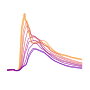

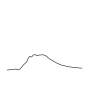

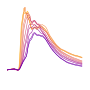

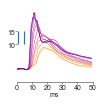

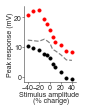

In [68]:


hfig,ax = create_fig()
colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
colinds = array([c for c in reversed(colinds)])
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample2_uncoupled')

hfig,ax = create_fig()
ax.plot(xtime-0.5,cd_R,color = 'black',lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines((0.005 - cd_offset)*1000,0,3)
figsave(figure_folder,'Fig4_outputcellExample2_cd')

hfig,ax = create_fig()
# colinds = plt.cm.plasma(np.linspace(0.2,0.85,11))
# colinds = array([c for c in reversed(colinds)])
# trialmat = trialmat[:,restrict_inds]
# trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep+cd_R,color = colinds[i],lw = 0.5);
ax.set_xlim(0,50)
ax.set_ylim(-5,25)
ax.set_xticks([])
ax.set_yticks([])
# ax.vlines(5,0,5)
figsave(figure_folder,'Fig4_outputcellExample2_predicted')


hfig,ax = create_fig()
trialmat = trialmat[:,restrict_inds]
trialmat = array([sweep for sweep in reversed(trialmat.T)]).T
for i,sweep in enumerate(trialmat.T):
    ax.plot(xtime-0.5,sweep,color = colinds[i],lw = 0.5);
    
ax.vlines(4.5,10,15)
ax.vlines(0.5,10,15)
sns.despine(hfig)
ax.set_xticks(np.arange(0,55,10))
plt.xlim(0,50)
ax.set_ylim(-5,25)
ax.set_yticks([10,15])
ax.set_frame_on(True)
yax = ax.spines["left"]
yax.set_visible(False)
ax.set_xlabel('ms');

figsave(figure_folder,'Fig4_outputcellExample2_coupled')

hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_uc)],
            color = 'black',s=10)
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_c)],
            color = 'red',s=10)
ax.set_ylabel('Peak response (mV)')
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.75)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig4_outputcellExample2_scatter')


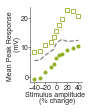

In [12]:
hfig,ax = create_fig_tuning()
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_uc],
            color = sns.xkcd_rgb['icky green'],s=10,marker = 'o')
# plt.scatter(stim_ampshift[restrict_inds],[a for a in reversed(Ramp_p)],
#             color = 'black',s=10, marker = '*')
plt.plot(stim_ampshift[restrict_inds],[a for a in Ramp_p],
            color = 'gray',linestyle='--')
plt.scatter(stim_ampshift[restrict_inds],[a for a in Ramp_c],
            edgecolors = sns.xkcd_rgb['icky green'],s=10,marker = 's',color='white')
ax.set_ylabel('Mean Peak Response \n (mV)',linespacing=0.9)
ax.set_xlabel('Stimulus amplitude \n (% change)',linespacing=0.9)
ax.set_xlim(-47,47)
xticks([-40,-20,0,20,40]);
sns.despine(hfig)
figsave(figure_folder,'Fig3_OutputE_Example1_scatter')